In [1]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
figsize(12.5,  4)

フォルダ作成＋データ読み込み

In [12]:
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXTVC", "data/txtdata")

('data/txtdata', <http.client.HTTPMessage at 0x1061d89e8>)

(0, 74)

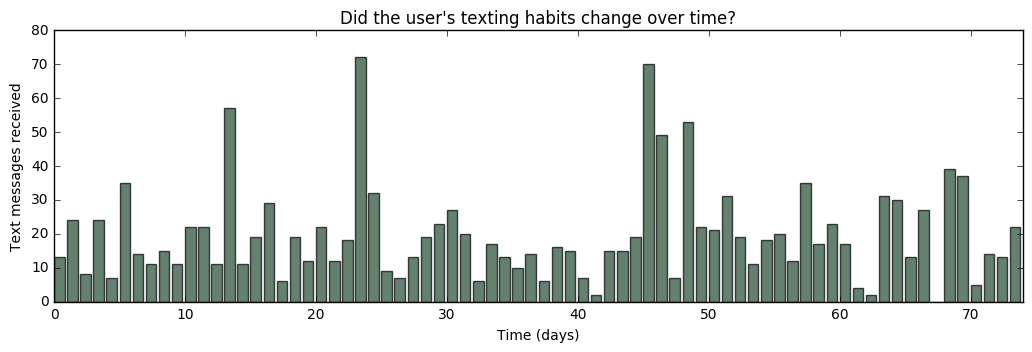

In [25]:
count_data  = np.loadtxt("data/txtdata")
n_count_data  = len(count_data)
plt.bar(np.arange(n_count_data),count_data,alpha=0.7, color="#234a32")
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

0以上の離散データなのでPoisson分布で考える。

i日目のメッセージ数を
$C_i$
とすると 

### $C_i  \sim Poi(\lambda)$

と書ける。

#### 急激に変化する場所 (SwitchPoint)がある場合, $\lambda$のあたいも切り替わるはずである。
$\lambda =\left\{
\begin{array}{ll}
\lambda_1 & (t \lt \tau) \\
\lambda_2 & (t \geq \tau)
\end{array}
\right.$
#### 変化がない場合は $\lambda_1 = \lambda_2$ となる。
そのため、二つの未知数$\lambda_1$と$\lambda_2$を推測すればいい。

$\lambda$は「正の実数」になるので、指数分布がちょうど良い。

### $\lambda_1 \sim \exp(\alpha) $
### $\lambda_2 \sim \exp(\alpha) $
$\alpha$
はハイパーパラメータである。ここでは単に係数データの平均値の逆数とする。

### $\frac{1}{N} \sum_{i=0}^N C_i \simeq E[\lambda|\alpha] = \frac{1}{\alpha}   $
変化点($\tau$)は決められないので、一様分布（uniform distribution)を利用する。

### $\tau \sim  DiscreteUniform(1, 70) \Rightarrow P(\tau=k) = \frac{1}{70} $

In [30]:
#pymc の導入
import pymc as pm

alpha = 1.0 / count_data.mean()
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [33]:
# 呼び出しの練習
print("Random outout", tau.random(), tau.random(),  tau.random())

Random outout 23 4 67


In [35]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[tau:]=lambda_1
    out[:tau]=lambda_2
    return out

### 

In [36]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

### MCMCの学習ステップ

In [37]:
mcmc = pm.MCMC(model)
mcmc.sample(40000,10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 4.5 sec

In [46]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace("tau")[:]

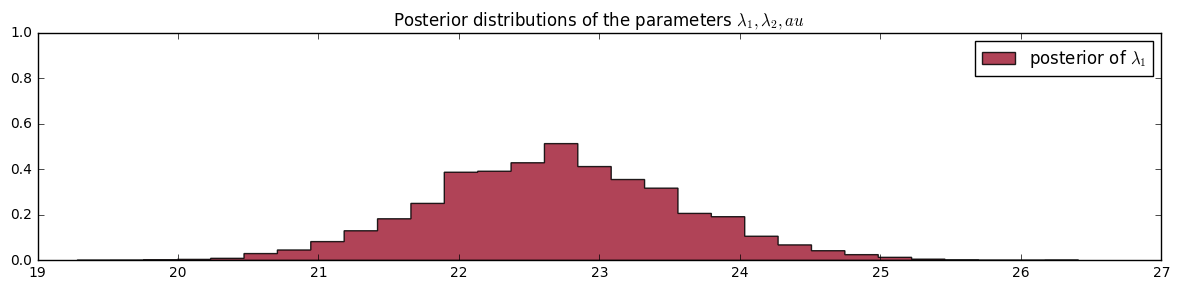

In [59]:
#プロット
figsize(14.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype="stepfilled", bins=30, alpha=0.85, color="#a2223a", normed=True, label="posterior of $\lambda_1$")
plt.legend(loc="upper right")
plt.title("Posterior distributions of the parameters $\lambda_1, \lambda_2,  \tau$")